In [5]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from mpl_toolkits import mplot3d

As of Mon 12th of Oct running on devel branch of GPy 0.8.8

In [6]:
GPy.plotting.change_plotting_library('matplotlib')

# Gaussian process regression tutorial

### Nicolas Durrande 2013
#### with edits by James Hensman and Neil D. Lawrence

We will see in this tutorial the basics for building a 1 dimensional and a 2 dimensional Gaussian process regression model, also known as a kriging model.

We first import the libraries we will need:

In [7]:
import numpy as np

## 1-dimensional model

For this toy example, we assume we have the following inputs and outputs:

In [178]:
#t = np.linspace(-10, 10, 500)
#y = np.sin(t * 1) * np.sin(t / 5)**5
datafile = '/Users/litz/Documents/GitHub/data/sg_simple_grid_mixed_modes/m1.0_feh0.5_MLT1.9_fov0.018.csv'
data = pd.read_csv(datafile)
mode_l = '1'
mode_n = '-5'

mode_freq = 'nu_'+ mode_l + '_' + mode_n
mode_inertia = 'E_'+ mode_l + '_' + mode_n

sub_df_name = ['initial_mass','initial_feh','star_age','effective_T','nu_max',mode_freq,mode_inertia]
sub_df = data[sub_df_name]
sub_df = sub_df.loc[((sub_df[mode_freq] > 0.4*sub_df['nu_max']) & (sub_df[mode_freq] < 1.6*sub_df['nu_max']))]
sub_df['star_age'] = sub_df['star_age']/1.0e9
sub_df[[mode_freq,mode_inertia]] = np.log10(sub_df[[mode_freq,mode_inertia]])
sub_df.head()



,initial_mass,initial_feh,star_age,effective_T,nu_max,nu_1_-5,E_1_-5
1383,1.0,0.5,11.164973,5281.160862,1020.222560,2.614217,-4.457800
1384,1.0,0.5,11.170401,5273.422111,1015.204139,2.616819,-4.441925
1385,1.0,0.5,11.175739,5265.767034,1010.204598,2.619481,-4.453069
1386,1.0,0.5,11.180993,5258.194229,1005.230871,2.622135,-4.491417
1387,1.0,0.5,11.186168,5250.672674,1000.269440,2.624717,-4.558720


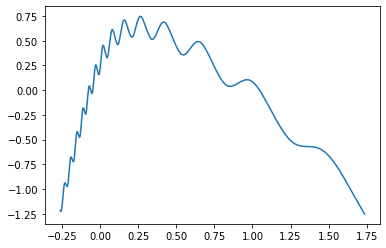

In [179]:
X0 = sub_df['effective_T'].to_numpy()
Y0 = sub_df[mode_freq].to_numpy()
X = (X0 - np.median(X0))/(np.max(X0) - np.min(X0))*2.0
Y = (Y0 - np.median(Y0))/(np.max(Y0) - np.min(Y0))*2.0

#X = np.random.uniform(-3.,3.,(20,1)) 
#Y = np.sin(X) + np.random.randn(20,1)*0.05

X = X.reshape(len(X0), 1)
Y = Y.reshape(len(X0), 1)

fig, ax = plt.subplots()
ax.plot(X, Y)

Note that the observations Y include some noise.

The first step is to define the covariance kernel we want to use for the model. We choose here a kernel based on Gaussian kernel (i.e. rbf or square exponential):

{'covariance': [[<matplotlib.lines.Line2D at 0x1b4817fe90>]]}

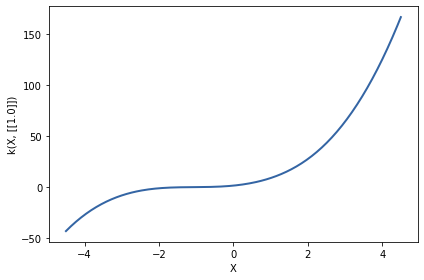

In [187]:
rbf = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
rbf2 = GPy.kern.RBF(input_dim=1, variance=0.01, lengthscale=1.)
periodicE = GPy.kern.PeriodicExponential(1)   #(input_dim=1, variance=0.01, lengthscale=1.)
poly = GPy.kern.Poly(1)
linear = GPy.kern.Linear(1)

#kernel = linear*linear + rbf # fail to reproduce the small variations
#kernel = rbf + rbf2 #works well
kernel = rbf + poly #works well
#kernel = poly + periodicE #periodic is uniform period
#kernel = rbf + periodicE #works well
#kernel = linear*periodicE + rbf #not good
kernel.plot()

The parameter input_dim stands for the dimension of the input space. The parameters `variance` and `lengthscale` are optional, and default to 1. Many other kernels are implemented, type `GPy.kern.<tab>` to see a list

In [188]:
#type GPy.kern.<tab> here:
#GPy.kern.BasisFuncKernel?

The inputs required for building the model are the observations and the kernel:

In [189]:
m = GPy.models.GPRegression(X,Y,kernel)

By default, some observation noise is added to the model. The functions `display` and `plot` give an insight of the model we have just built:

In [190]:
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,1.0,+ve,
sum.poly.variance,1.0,+ve,
sum.poly.scale,1.0,+ve,
sum.poly.bias,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


AttributeError: 'dict' object has no attribute 'figure'

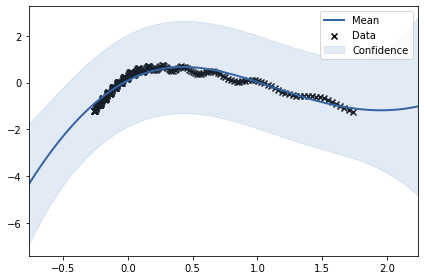

In [191]:
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

The above cell shows our GP regression model before optimization of the parameters. The shaded region corresponds to ~95% confidence intervals (ie +/- 2 standard deviation).

The default values of the kernel parameters may not be optimal for the current data (for example, the confidence intervals seems too wide on the previous figure). A common approach is to find the values of the parameters that maximize the likelihood of the data. It as easy as calling `m.optimize` in GPy:

In [192]:
m.optimize(messages=True)

If we want to perform some restarts to try to improve the result of the optimization, we can use the `optimize_restarts` function. This selects random (drawn from $N(0,1)$) initializations for the parameter values, optimizes each, and sets the model to the best solution found.

In [194]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -282.03262972940973
Optimization restart 2/10, f = -275.56616205722133
Optimization restart 3/10, f = -275.5661627295392
Optimization restart 4/10, f = -282.03262973138976
Optimization restart 5/10, f = -282.03262972922386
Optimization restart 6/10, f = -282.0326296853316
Optimization restart 7/10, f = -282.0326297291607
Optimization restart 8/10, f = -282.032629733392
Optimization restart 9/10, f = -282.0326293771397
Optimization restart 10/10, f = -677.9265883864898


In this simple example, the objective function (usually!) has only one local minima, and each of the found solutions are the same. 

Once again, we can use `print(m)` and `m.plot()` to look at the resulting model resulting model. This time, the paraemters values have been optimized agains the log likelihood (aka the log marginal likelihood): the fit shoul dbe much better. 

### New plotting of GPy 0.9 and later
The new plotting allows you to plot the density of a GP object more fine grained by plotting more percentiles of the distribution color coded by their opacity

GP_regression.,value,constraints,priors
sum.rbf.variance,0.013002255598151963,+ve,
sum.rbf.lengthscale,0.009839838759079232,+ve,
sum.poly.variance,1.1825009866492844,+ve,
sum.poly.scale,2.1242153428278785,+ve,
sum.poly.bias,0.7159077405022495,+ve,
Gaussian_noise.variance,2.395226011833334e-07,+ve,


AttributeError: 'dict' object has no attribute 'figure'

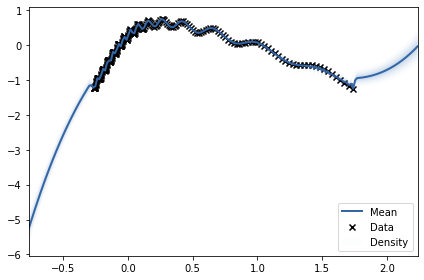

In [195]:
display(m)
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

## 2-dimensional example

Here is a 2 dimensional example:

In [177]:
dr = '/Users/litz/Documents/GitHub/data/sg_simple_grid_mixed_modes/'
files = glob.glob(dr + "*.csv")
temp = []
for filename in files:
    df0 = pd.read_csv(filename, index_col=0)
    temp.append(df0)
data_2d = pd.concat(temp, axis = 0, ignore_index=True)
data_2d['mean_density'] = data_2d['initial_mass']/data_2d['radius']**3.0
data_2d.head()

KeyboardInterrupt: 

In [71]:
mode_l = '1'
mode_n = '-5'

mode_freq = 'nu_'+ mode_l + '_' + mode_n
mode_inertia = 'E_'+ mode_l + '_' + mode_n

sub_df_name = ['initial_mass','mean_density','star_age','effective_T','nu_max',mode_freq,mode_inertia]
sub_df = data_2d[sub_df_name]
sub_df = sub_df.loc[((sub_df[mode_freq] > 0.5*sub_df['nu_max']) & (sub_df[mode_freq] < 1.5*sub_df['nu_max']) & (sub_df['initial_mass'] < 1.2) )]
sub_df['star_age'] = sub_df['star_age']/1.0e9
sub_df[[mode_freq,mode_inertia]] = np.log10(sub_df[[mode_freq,mode_inertia]])
sub_df.head()

,initial_mass,mean_density,star_age,effective_T,nu_max,nu_1_-5,E_1_-5
3123,1.19,0.120887,5.766263,5407.468298,827.462247,2.618502,-5.574694
3124,1.19,0.120289,5.769098,5398.908799,825.386398,2.619962,-5.678686
3125,1.19,0.119690,5.771910,5390.417313,823.288911,2.621019,-5.759493
3126,1.19,0.119088,5.774702,5381.990234,821.168795,2.621743,-5.813664
3127,1.19,0.118474,5.777476,5373.524917,818.986905,2.622238,-5.843494


7246


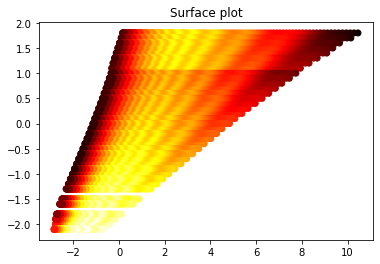

In [23]:
mass = sub_df['initial_mass'].to_numpy()
teff = sub_df['effective_T'].to_numpy()
nu = sub_df[mode_freq].to_numpy()
mass_n = (mass - np.median(mass))/0.1
teff_n= (teff - np.median(teff))/50
nu_n = (nu - np.median(nu))/0.03

print(len(mass_n))

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot_surface(teff_n, mass_n, np.diag(nu_n) ,cmap='viridis', edgecolor='none')
fig, ax = plt.subplots()
ax.scatter(teff_n, mass_n, c = nu_n, cmap = 'hot')
ax.set_title('Surface plot')
plt.show()

In [17]:
teff_n = teff_n.reshape(len(teff_n),1)
mass_n = mass_n.reshape(len(teff_n),1)

In [18]:
X = np.concatenate((teff_n, mass_n), axis = 1)
Y = nu_n.reshape(len(teff_n),1)

In [27]:
# sample inputs and outputs
#X = np.random.uniform(-3.,3.,(50,2))
#Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2])+np.random.randn(50,1)*0.05

# define kernel
ker = GPy.kern.Matern52(2,ARD=True) #GPy.kern.RBF(input_dim=2)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 100)

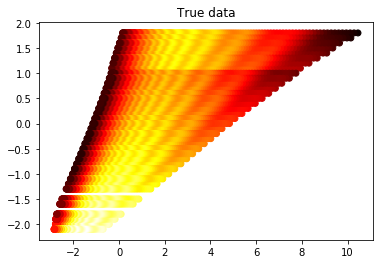

AttributeError: 'dict' object has no attribute 'figure'

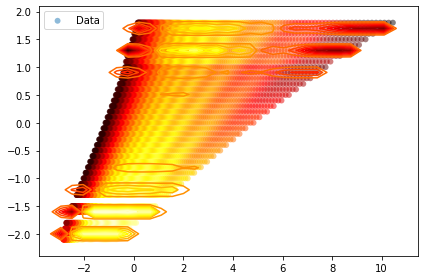

In [28]:
fig, ax = plt.subplots()
ax.scatter(teff_n, mass_n, c = nu_n, cmap = 'hot')
ax.set_title('True data')
plt.show()

fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d')
display(m)
plt.set_title('GP prediction (Matern52)')
plt.show()

The flag `ARD=True` in the definition of the `Matern` kernel specifies that we want one lengthscale parameter per dimension (ie the GP is not isotropic). Note that for 2-d plotting, only the mean is shown. 

In [29]:
# sample inputs and outputs
#X = np.random.uniform(-3.,3.,(50,2))
#Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2])+np.random.randn(50,1)*0.05

# define kernel
ker = GPy.kern.Matern32(2,ARD=True) #GPy.kern.RBF(input_dim=2)

# create simple GP model
m_Matern32 = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m_Matern32.optimize(messages=True,max_f_eval = 100)

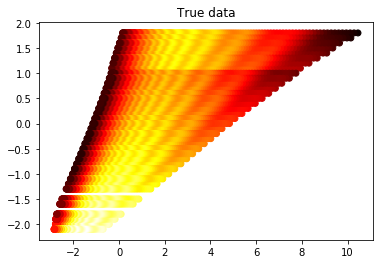

AttributeError: 'dict' object has no attribute 'figure'

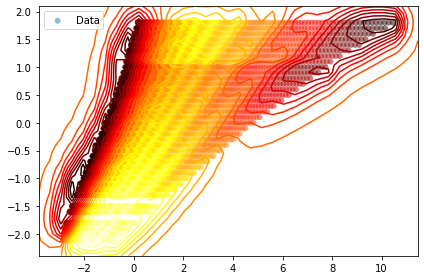

In [30]:
fig, ax = plt.subplots()
ax.scatter(teff_n, mass_n, c = nu_n, cmap = 'hot')
ax.set_title('True data')
plt.show()

fig = m_Matern32.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d')
display(m_Matern32)
plt.set_title('GP prediction (Matern32)')
plt.show()

## Plotting slices
To see the uncertaintly associated with the above predictions, we can plot slices through the surface. this is done by passing the optional `fixed_inputs` argument to the plot function. `fixed_inputs` is a list of tuples containing which of the inputs to fix, and to which value.

To get horixontal slices of the above GP, we'll fix second (index 1) input to -1, 0, and 1.5:

In [ ]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

A few things to note:
 * we've also passed the optional `ax` argument, to mnake the GP plot on a particular subplot
 * the data look strange here: we're seeing slices of the GP, but all the data are displayed, even though they might not be close to the current slice.

To get vertical slices, we simply fixed the other input. We'll turn the display of data off also:

In [ ]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')

You can find a host of other plotting options in the `m.plot` docstring. `Type m.plot?<enter>` to see. 